In [4]:
import math
import copy
import numpy as np
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
import cvxpy as cp  
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [5]:
def compute_guidance_cvx(state,ineq_constr,tf,delt):
    ###############################################
    s_time = time.time()

    N = int(tf/delt)
    
    pos0 = state[0]
    vel0 = state[1]
    pos_des = state[2]
    vel_des = state[3]
    g = np.array([0,0,9.807])
    Alpha = 1/( 300 * 9.807)

    z_min = ineq_constr[0]
    z_max = ineq_constr[1]
    Mu1 = ineq_constr[2]
    Mu2 = ineq_constr[3]
    ###############################################
    u = cp.Variable((3,N))
    r = cp.Variable((3,N+1))
    v = cp.Variable((3,N+1))
    sigma = cp.Variable((N))
    z = cp.Variable((N+1))

    obj=cp.Minimize(cp.norm(sigma,2))
    
    constr = [ r[:,0] == pos0,
               v[:,0] == vel0,
               r[:,-1] == pos_des,
               v[:,-1] == vel_des,
               z[0] == z_min[0]
               ]

    for t in range(N):
        constr += [            
            r[:,t+1] == r[:,t] + delt*(v[:,t]),
            v[:,t+1] == v[:,t] + delt*(u[:,t]+g),
            z[t+1] == z[t] - Alpha*delt*sigma[t],
            cp.norm(u[:,t]) <= sigma[t],
            z_min[t] <= z[t],
            z_max[t] >= z[t],
            Mu1[t]*(1-(z[t]-z_min[t])) <= sigma[t],
            Mu2[t]*(1-(z[t]-z_min[t])) >= sigma[t],
            # r[2,:] <= 0,
            u[2,:] <= 0,
            ]

    #마지막 step일때 구속조건    
    constr += [
        cp.norm(u[:,-1]) <= sigma[-1],
        sigma[-1] <= Mu2[-1]*(1 - (z[-1] - z_min[-1]) ),
        Mu1[-1]*(1 - (z[-1]-z_min[-1])) <= sigma[-1],
        z_min[-1] <= z[-1],
        z[-1] <= z_max[-1]
        ]

    cp.Problem(obj, constr).solve(solver=cp.ECOS,verbose=False,abstol=1e-4,reltol=1e-4)
    e_time = time.time()
    ###############################################
    u_opt = u.value
    r_opt = r.value
    v_opt = v.value
    z_opt = z.value
    sigma_opt = sigma.value

    thrust = np.linalg.norm(u_opt,axis=0)
    print("consensus admm: ", np.linalg.norm(thrust))
    print("computing time: %.4f" %(e_time - s_time))
    return np.array([u_opt,sigma_opt,z_opt,r_opt,v_opt])

In [79]:
def proj_onto_trapezoid(sigma_i,z_i,z_min,z_max,Mu1,Mu2):
    x = z_i
    y = sigma_i

    if Mu2*x +y -Mu2*(z_min+1) <= 0 and Mu1*x + y -Mu1*(z_min+1) >= 0 and x >= z_min and x <= z_max:
        x = z_i
        y = sigma_i
        # print("region already fesible")
    
    elif -1/Mu2*x + y +z_min/Mu2 - Mu2>=0 and y>=Mu2:
        x = z_min
        y = Mu2
        # print("region1")

    elif y<=Mu2 and y>=Mu1 and x <= z_min:
        x = z_min
        y = sigma_i
        # print("region2")

    elif y<=Mu1 and -1/Mu1*x + y + z_min/Mu1 - Mu1>=0:
        x = z_min
        y = Mu1
        # print("region3")
    elif -1/Mu1*x + y + z_min/Mu1 + Mu1<=0 and -1/Mu1*x + y + z_max/Mu1 -Mu1*(z_min-z_max+1)>=0 and Mu1*x + y -Mu1*(z_min+1) < 0:
        x = -(z_min+1 - z_i + Mu1*sigma_i)/(Mu1**2+1) + z_min+1
        y = Mu1*(z_min+1-z_i + Mu1*sigma_i)/(Mu1**2+1)
        # print("region4")

    elif -1/Mu1*x + y + z_max/Mu1 -Mu1*(z_min-z_max+1) < 0 and y < Mu1*(z_min-z_max+1):
        x = z_max
        y = Mu1*(z_min-z_max+1)
        # print("region5")
    
    elif y >= Mu1*(z_min-z_max+1) and y <= Mu2*(z_min-z_max+1) and x > z_max:
        x = z_max
        y = sigma_i
        # print("region6")

    elif y > Mu2*(z_min-z_max+1) and -1/Mu2*x + y + z_max/Mu2 - Mu2*(z_min - z_max +1) < 0:
        x = z_max
        y = Mu2*(z_min-z_max+1)
        # print("region7")
    
    elif -1/Mu2*x + y + z_max/Mu2 - Mu2*(z_min - z_max +1) >= 0 and -1/Mu2*x + y +z_min/Mu2 - Mu2 < 0 and Mu2*x +y -Mu2*(z_min+1) >= 0:
        x = -(z_min+1 - z_i+Mu2*sigma_i)/(Mu2**2+1) + z_min+1
        y = Mu2*(z_min+1 - z_i+Mu2*sigma_i)/(Mu2**2+1)
        # print("region8")

    return y,x

def proj_onto_soc(u_i,sigma_i):
    T_N,T_E,T_D = u_i[:3] 
    thrust = np.linalg.norm(u_i)

    if thrust > sigma_i:
        update_var = (thrust+sigma_i)/2
        T_N = update_var*T_N/thrust
        T_E = update_var*T_E/thrust
        T_D = update_var*T_D/thrust
        sigma_i = update_var
    
    u_i[:] = T_N,T_E,T_D

    return u_i,sigma_i

def proj_onto_inner_product_cone(u,theta,z_i):
    m_prev = np.exp(z_i[0])
    m_next = np.exp(z_i[1])
    u_prev = u[:3]*m_prev
    u_next = u[3:]*m_next

    norm_prev = np.linalg.norm(u_prev)
    norm_next = np.linalg.norm(u_next)
    cos_alpha = u_prev@u_next.T/(norm_prev*norm_next)
    alpha = np.arccos(cos_alpha)

    if  cos_alpha >= np.cos(theta):
        u_prev_update = u[:3]
        u_next_update = u[3:]
    
    else:
        K = alpha -theta
        psi = np.arctan2( norm_next**2*np.sin(2*K),(norm_prev**2 + norm_next**2*np.cos(2*K)) )
        phi = psi/2
        normal_vec = np.cross(u_prev,u_next)

        A = np.array([u_prev,u_next,normal_vec])
        b1 = np.array([norm_prev**2*np.cos(phi)**2,norm_prev*norm_next*np.cos(phi)*np.cos(alpha-phi),0])
        b2 = np.array([norm_prev*norm_next*np.cos(K-phi)*np.cos(theta+phi),norm_next**2*np.cos(K-phi)**2,0])

        u_prev_update = np.linalg.solve(A,b1)/m_prev
        u_next_update = np.linalg.solve(A,b2)/m_next

    return u_prev_update, u_next_update

In [145]:
 def ADMM_consensus_compute_guidance(state,ineq_constr,tf,theta,delt):
    s_time = time.time()
    N = int(tf/delt)
    
    if N == 0 or N == 1:
        u,sigma,z,pos_pin,vel_pin = 0, 0, 0, 0 
        return np.array([u,sigma,z,pos_pin,vel_pin]) 
    ############################################################################
    # initial and desire state
    pos_0 = state[0]
    vel_0 = state[1]
    pos_des = state[2]
    vel_des = state[3]
    g = np.array([0,0,9.807])
    Alpha = 1/( 300 * 9.807)

    z_min = ineq_constr[0]
    z_max = ineq_constr[1]
    Mu1 = ineq_constr[2]
    Mu2 = ineq_constr[3]
    z_0 = z_min[0]

    rho = 1e0
    lamb = 1e8
    ############################################################################
    # initialize static matrix
    G = np.zeros((3,3*N))
    H = np.zeros((3,3*N))
    I = np.eye(5*N)
    
    for i in range(N):
        G[:, 3*i:3*(i+1)] = (N-1-i)*delt**2*np.eye(3)
        H[:, 3*i:3*(i+1)] =  delt*np.eye(3)
    
    S_N = np.zeros(N)
    S_N[-1] = 1
    S_sigma = ssp.hstack((ssp.csr_matrix((N,3*N)),ssp.eye(N),ssp.csr_matrix((N,N)) ))

    A_col1 = ssp.vstack((ssp.csr_matrix(G),ssp.csr_matrix(H),ssp.csr_matrix((1,3*N)) ))
    A_col2 = ssp.vstack((ssp.csr_matrix((6,N)),Alpha*delt*np.ones(N)))
    A_col3 = ssp.vstack((ssp.csr_matrix((6,N)),S_N))
    A = ssp.hstack((A_col1,A_col2,A_col3))

    num_x_i = N+1
    sqrt_rholamb = np.sqrt(num_x_i*rho/(2*lamb))
    A_tilde = ssp.vstack(( A,S_sigma/np.sqrt(lamb) ))
    A_hat = ssp.vstack((A_tilde,sqrt_rholamb*I ))

    pos = pos_des - (pos_0 + N*delt*vel_0 + delt**2*(N-1)*N/2*g)
    vel = vel_des - (vel_0 + N*delt*g)
    
    b = np.hstack((pos,vel,z_0))
    b_tilde = np.hstack(( b,np.zeros(N) ))
    b_hat = np.zeros(7+6*N)
    b_hat[:N+7] = b_tilde
    b_l2 = np.linalg.norm(b)

    z = sla.lsqr(A_tilde,b_tilde)[0]        # z initialize (warm start)
    x_i = np.zeros((5*N,num_x_i))
    w_i = np.zeros((5*N,num_x_i))
    x_bar = np.zeros(5*N)
    w_bar = np.zeros(5*N)
    x_bar_last = z
    
    z_pin = np.zeros(N+1)
    z_pin[0] = z_0
    
    status = "Infeasible"
    max_iter = 1000

    for i in range(max_iter):
        for n in range(num_x_i):
            x_i[:,n] = z - w_i[:,n]

        ##################################################################################################
        for t in range(N):          # x_i update
            x_i[3*t:3*(t+1),0],x_i[3*N+t,0] = proj_onto_soc(x_i[3*t:3*(t+1),0],x_i[3*N+t,0])                                # projection u, sigma
            x_i[3*N+t,1], x_i[4*N+t,1] = proj_onto_trapezoid(x_i[3*N+t,1],x_i[4*N+t,1],z_min[t],z_max[t],Mu1[t],Mu2[t])               # projection sigma, z
        for t in range(N):
            z_pin[t+1] = z_pin[t] - Alpha*delt*z[3*N+t]
            if t <= N-2:
                x_i[:,t+2] = x_i[:,0]
                x_i[3*t:3*(t+1),t+2],x_i[3*(t+1):3*(t+2),t+2] = proj_onto_inner_product_cone(x_i[3*t:3*(t+2),t+2],theta,z_pin[t:t+2])    # projection u onto desire degree set

        for t in range(N):
            # sigma,z average
            x_bar[3*N+t] = (x_i[3*N+t,0] + x_i[3*N+t,1])/2
            x_bar[4*N+t] = x_i[4*N+t,1]
            w_bar[3*N+t] = (w_i[3*N+t,0] + w_i[3*N+t,1])/2
            w_bar[4*N+t] = w_i[4*N+t,1]
            x_bar[3*t:3*(t+1)] = x_i[3*t:3*(t+1),0]
            w_bar[3*t:3*(t+1)] = w_i[3*t:3*(t+1),0]

            # u average
            if t == 0:
                x_bar[:3] = (x_i[:3,0]+x_i[:3,2])/2
                w_bar[:3] = (w_i[:3,0]+w_i[:3,2])/2
            elif t == N-1:
                x_bar[3*(N-1):3*N] = (x_i[3*(N-1):3*N,0] + x_i[3*(N-1):3*N,N])/2
                w_bar[3*(N-1):3*N] = (w_i[3*(N-1):3*N,0] + w_i[3*(N-1):3*N,N])/2
            else:
                x_bar[3*t:3*(t+1)] = (x_i[3*t:3*(t+1),0] + x_i[3*t:3*(t+1),t+1] + x_i[3*t:3*(t+1),t+2])/3
                w_bar[3*t:3*(t+1)] = (w_i[3*t:3*(t+1),0] + w_i[3*t:3*(t+1),t+1] + w_i[3*t:3*(t+1),t+2])/3
        ################################################################################################## 
        # z update 
        b_hat[N+7:] = sqrt_rholamb*(x_bar+w_bar)
        z, istop = sla.lsqr(A_hat,b_hat)[:2]
        ##################################################################################################
        # w update
        for n in range(num_x_i):
            w_i[:,n] = w_i[:,n] + x_i[:,n] - z                  # dual ascent
        ##################################################################################################
        # Stopping Criterion 
        r = np.linalg.norm((x_i.T - x_bar),'fro')**2        # Primal residual
        s = num_x_i*rho**2*((np.linalg.norm(x_bar - x_bar_last))**2)                             # Dual residual
        Ax = x_i.flatten('F')
        ATyk = rho*w_i.flatten('F')
        primal_res_l2 = np.sqrt(r)
        dual_res_l2 = np.sqrt(s)

        abstol, reltol = 1e-8, 1e-5
        ptol = np.sqrt(5*N*num_x_i)*abstol + reltol*max(np.linalg.norm(Ax), np.sqrt(num_x_i)*np.linalg.norm(z))
        dtol = np.sqrt(5*N*num_x_i)*abstol + reltol*np.linalg.norm((ATyk))
        x_bar_last = x_bar
        r,s = 0,0

        if  primal_res_l2 <= ptol and dual_res_l2 <= dtol:    # Stopping Criteria
            status = "Solved"
            break
        #################################################################################################

    e_time = time.time()
    print("iter:",i,"status:",status,"pres_l2:",primal_res_l2, "dres_l2:",dual_res_l2,"ptol:", ptol,"dtol:",dtol)

    if pos_0[2]>=0 or istop == 0 or status == "Infeasible":
        u = z[:3*N]
        sigma = z[3*N:4*N]
        z = z[4*N:]
    else:
        u = z[:3*N]
        sigma = z[3*N:4*N]
        z = z[4*N:]

    pos_pin = np.zeros((3,N+1))
    vel_pin = np.zeros((3,N+1))
    z_pin = np.zeros(N+1)
    pos_pin[:,0] = pos_0
    vel_pin[:,0] = vel_0
    z_pin[0] = z_0
    for t in range(N):
        pos_pin[:,t+1] = pos_pin[:,t] + vel_pin[:,t]*delt
        vel_pin[:,t+1] = vel_pin[:,t] + (u[3*t:3*(t+1)] + g )*delt
        z_pin[t+1] = z_pin[t] - Alpha*delt*sigma[t]

    thrust = np.linalg.norm(np.reshape(u,(3,N),order='F'),axis=0)
    print("consensus admm: ", np.linalg.norm(thrust))
    print("computing time: ", (e_time - s_time))
    return np.array([u,sigma,z,pos_pin,vel_pin,z_pin])    

In [214]:
tf = 23
delt = 1
N = int(tf/delt)
ts = np.linspace(0,tf,N+1)

degree = 9
theta = degree*np.pi/180

pos0 = np.array([500,300,-500])
vel0 = np.array([50,-50,70])
pos_des = np.array([0,0,0])
vel_des = np.array([0,0,0])

Thr_ub = 2.5e+5
Thr_lb = 1e+5
Alpha = 1/( 300 * 9.807)
Mass = 1.5e+4

z_min=np.zeros(N)
z_max=np.zeros(N)
Mu1=np.zeros(N)
Mu2=np.zeros(N)

for t in range(N):
    z_min[t]=math.log(Mass-Alpha*Thr_ub*t*delt)
    z_max[t]=math.log(Mass-Alpha*Thr_lb*t*delt)
    Mu1[t]=Thr_lb*math.exp(-z_min[t])
    Mu2[t]=Thr_ub*math.exp(-z_min[t])

state = np.array([pos0,vel0,pos_des,vel_des])
ineq_constr = np.array([z_min,z_max,Mu1,Mu2]) 

In [215]:
u,sigma,z,r,v = compute_guidance_cvx(state,ineq_constr,tf,delt)
u_ADMM,sigma_ADMM,z_ADMM,r_ADMM,v_ADMM,z_recal = ADMM_consensus_compute_guidance(state,ineq_constr,tf,theta,delt)

consensus admm:  76.04180162393739
computing time: 0.3936
iter: 471 status: Solved pres_l2: 0.005745140488189939 dres_l2: 0.0 ptol: 0.0057473658651890636 dtol: 0.0020928897635179556
consensus admm:  76.33522630818806
computing time:  1.6138300895690918


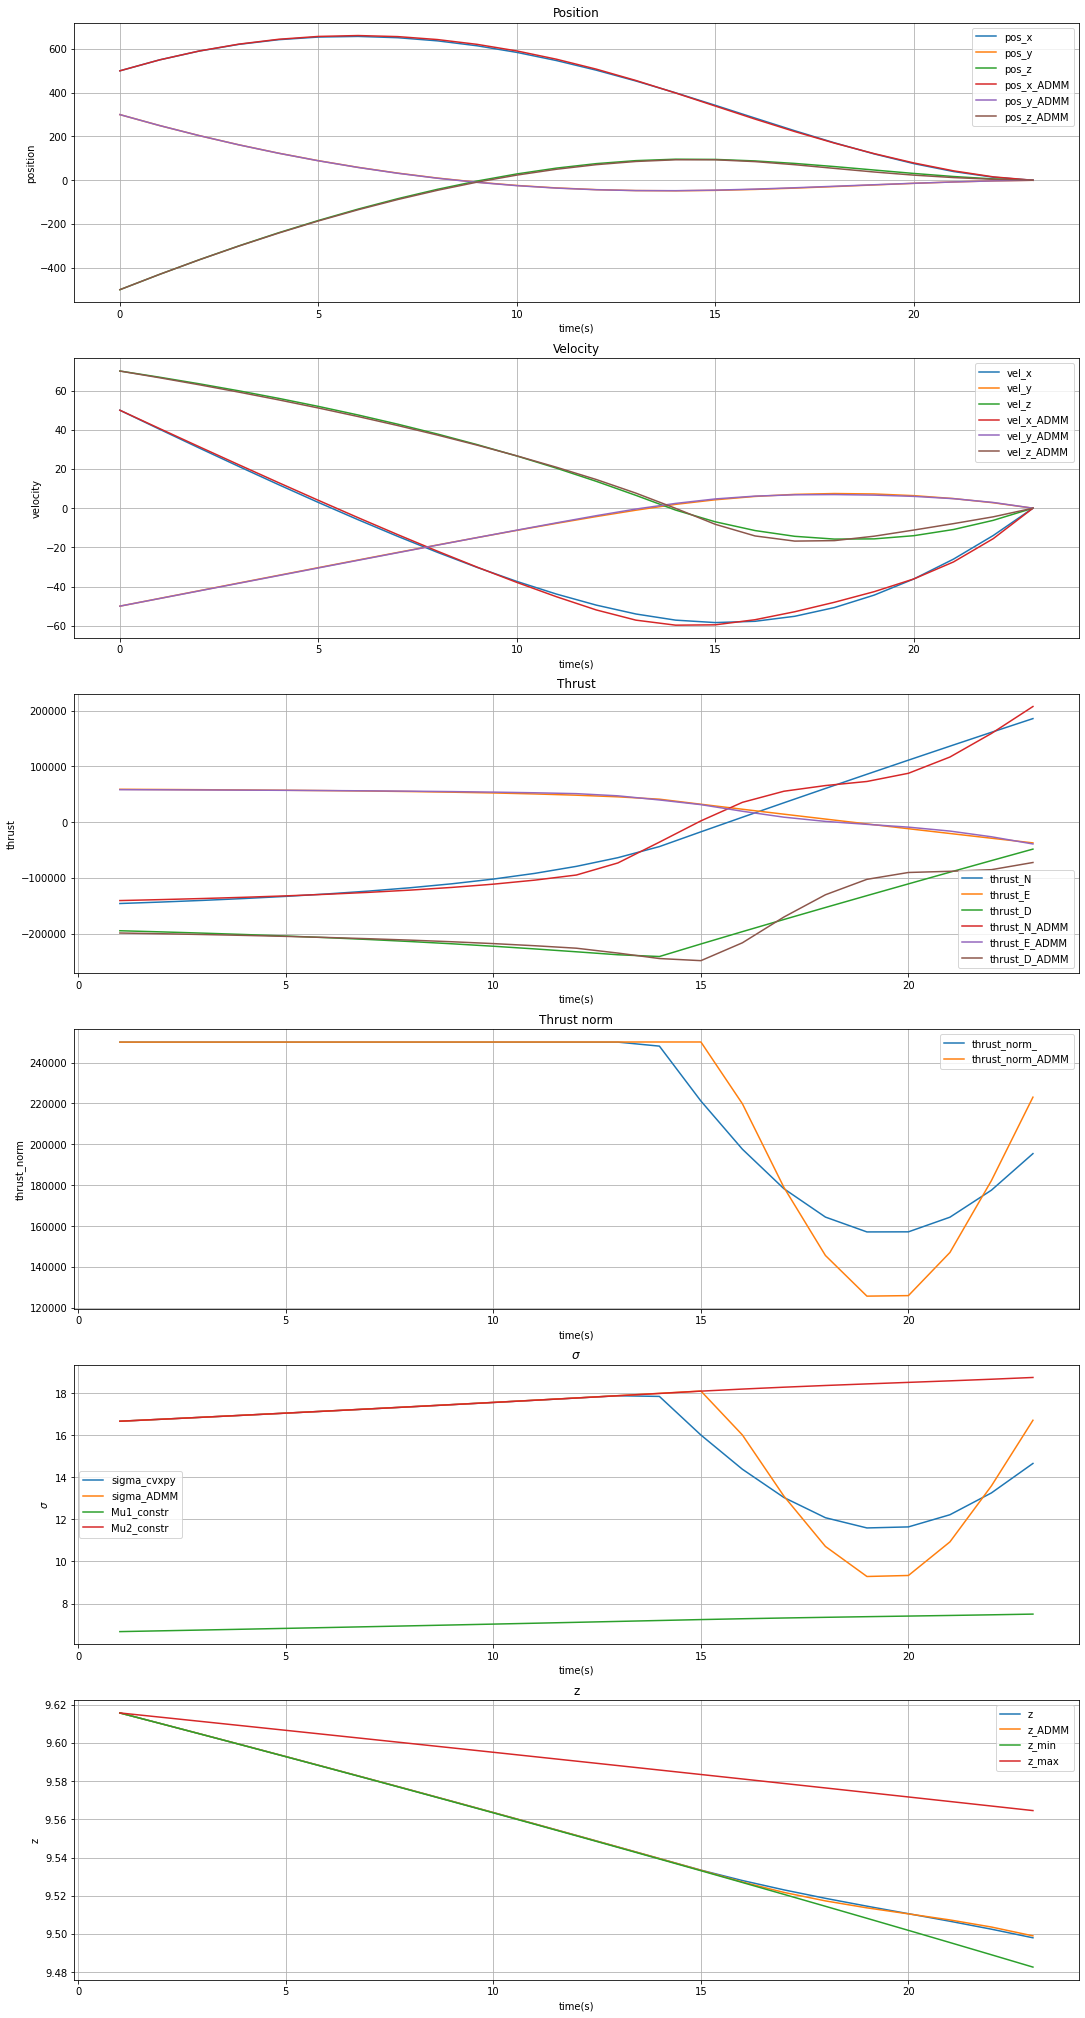

In [216]:
u_ADMM_NED = np.exp(z_recal[:-1])*(np.reshape(u_ADMM,(3,N),order='F'))
u_NED = np.exp(z[:-1])*u
thrust = (np.linalg.norm(u_NED,axis=0))
thrust_ADMM = np.linalg.norm(u_ADMM_NED,axis=0)
Mu1_constr = Mu1*(1-z[:-1]+z_min)
Mu2_constr = Mu2*(1-z[:-1]+z_min) 

plt.figure(figsize=(18,36))
plt.subplot(611)
plt.plot(ts,r[0,:],label='pos_x')
plt.plot(ts,r[1,:],label='pos_y')
plt.plot(ts,r[2,:],label='pos_z')
plt.plot(ts,r_ADMM[0,:],label='pos_x_ADMM')
plt.plot(ts,r_ADMM[1,:],label='pos_y_ADMM')
plt.plot(ts,r_ADMM[2,:],label='pos_z_ADMM')
plt.title('Position')
plt.xlabel('time(s)')
plt.ylabel('position')
plt.legend()
plt.grid()

plt.subplot(612)
plt.plot(ts,v[0,:],label='vel_x')
plt.plot(ts,v[1,:],label='vel_y')
plt.plot(ts,v[2,:],label='vel_z')
plt.plot(ts,v_ADMM[0,:],label='vel_x_ADMM')
plt.plot(ts,v_ADMM[1,:],label='vel_y_ADMM')
plt.plot(ts,v_ADMM[2,:],label='vel_z_ADMM')
plt.title('Velocity')
plt.xlabel('time(s)')
plt.ylabel('velocity')
plt.legend()
plt.grid()

plt.subplot(613)
plt.plot(ts[1:],u_NED[0,:],label='thrust_N')
plt.plot(ts[1:],u_NED[1,:],label='thrust_E')
plt.plot(ts[1:],u_NED[2,:],label='thrust_D')
plt.plot(ts[1:],u_ADMM_NED[0,:],label='thrust_N_ADMM')
plt.plot(ts[1:],u_ADMM_NED[1,:],label='thrust_E_ADMM')
plt.plot(ts[1:],u_ADMM_NED[2,:],label='thrust_D_ADMM')
plt.title('Thrust')
plt.xlabel('time(s)')
plt.ylabel('thrust')
plt.legend()
plt.grid()

plt.subplot(614)
plt.plot(ts[1:],thrust,label='thrust_norm_')
plt.plot(ts[1:],thrust_ADMM,label='thrust_norm_ADMM')
plt.title('Thrust norm')
plt.xlabel('time(s)')
plt.ylabel('thrust_norm')
plt.legend()
plt.grid()

plt.subplot(615)
plt.plot(ts[1:],sigma,label='sigma_cvxpy')
plt.plot(ts[1:],sigma_ADMM,label='sigma_ADMM')
plt.plot(ts[1:],Mu1_constr,label='Mu1_constr')
plt.plot(ts[1:],Mu2_constr,label='Mu2_constr')
plt.title(r'$\sigma$')
plt.xlabel('time(s)')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.grid()

plt.subplot(616)
plt.plot(ts[1:],z[:-1],label='z')
plt.plot(ts[1:],z_recal[:-1],label='z_ADMM')
plt.plot(ts[1:],z_min,label='z_min')
plt.plot(ts[1:],z_max,label='z_max')
plt.title('z')
plt.xlabel('time(s)')
plt.ylabel('z')
plt.legend()
plt.grid()

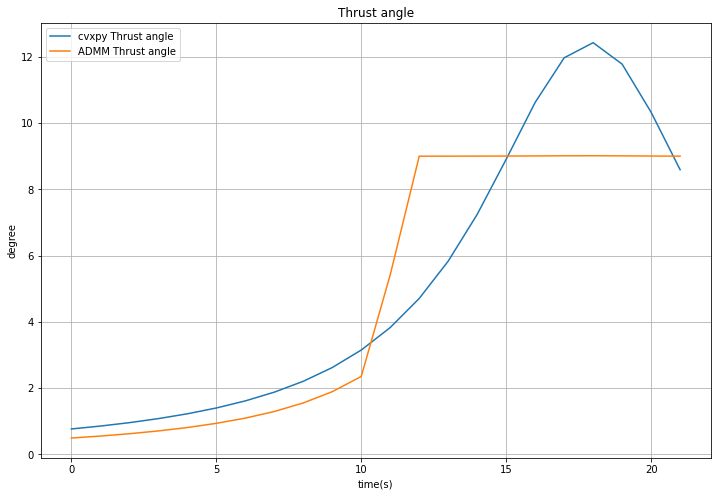

In [217]:
step_prev_ADMM = u_ADMM_NED[:,:-1]
thrust_prev_ADMM = thrust_ADMM[:-1]
step_next_ADMM = u_ADMM_NED[:,1:]
thrust_next_ADMM = thrust_ADMM[1:]

inner_product = np.sum((step_prev_ADMM*step_next_ADMM),axis=0)
angle_ADMM = np.arccos(inner_product/(thrust_prev_ADMM*thrust_next_ADMM))

step_prev = u_NED[:,:-1]
thrust_prev = thrust[:-1]
step_next = u_NED[:,1:]
thrust_next = thrust[1:]

inner_product = np.sum((step_prev*step_next),axis=0)
angle = np.arccos(inner_product/(thrust_prev*thrust_next))

plt.figure(figsize=(12,8))
plt.plot(angle*180/np.pi,label='cvxpy Thrust angle')
plt.plot(angle_ADMM*180/np.pi,label='ADMM Thrust angle')
plt.title('Thrust angle')
plt.xlabel('time(s)')
plt.ylabel('degree')
plt.legend()
plt.grid()

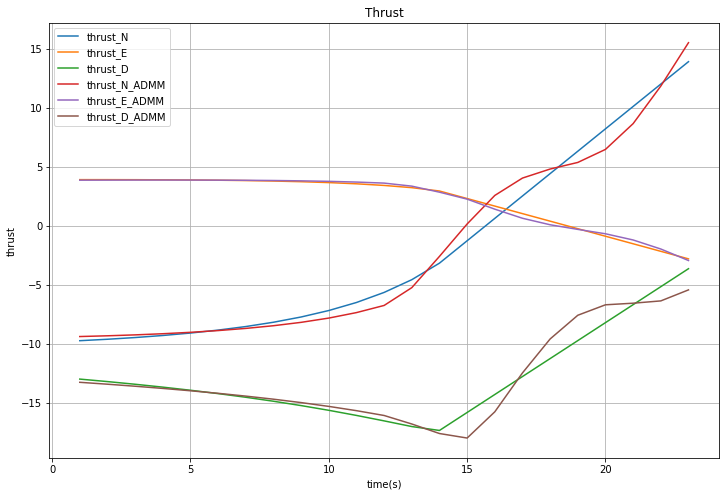

In [218]:
e_z = np.zeros((3,N))
e_z[2,:] = -1
angle = 180/np.pi*np.arccos(np.sum(u_ADMM_NED*e_z,axis=0)/(thrust_ADMM))

plt.figure(figsize=(12,8))
# plt.plot(angle)
# plt.grid()

plt.plot(ts[1:],u[0,:],label='thrust_N')
plt.plot(ts[1:],u[1,:],label='thrust_E')
plt.plot(ts[1:],u[2,:],label='thrust_D')
plt.plot(ts[1:],np.reshape(u_ADMM,(3,N),order='F')[0,:],label='thrust_N_ADMM')
plt.plot(ts[1:],np.reshape(u_ADMM,(3,N),order='F')[1,:],label='thrust_E_ADMM')
plt.plot(ts[1:],np.reshape(u_ADMM,(3,N),order='F')[2,:],label='thrust_D_ADMM')
plt.title('Thrust')
plt.xlabel('time(s)')
plt.ylabel('thrust')
plt.legend()
plt.grid()